In [1]:
%pip install pandas psycopg2-binary sqlalchemy matplotlib scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import psycopg2 as db
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

In [3]:
db_type = 'postgresql'
host = 'database'
port = 5432
db_name = os.environ.get('POSTGRES_DB')
user = os.environ.get('POSTGRES_USER')
password = os.environ.get('POSTGRES_PASSWORD')

conn_uri = f"{db_type}://{user}:{password}@{host}:{port}/{db_name}"
alchemyEngine = create_engine(conn_uri)
db_conn = alchemyEngine.connect();

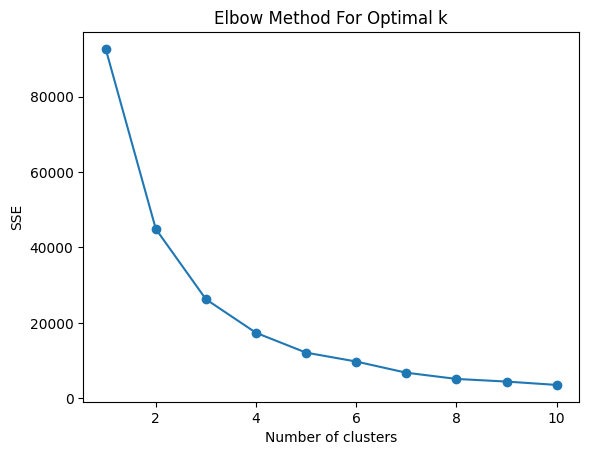

In [11]:
""" Plot Number of customers per day """
db_conn = alchemyEngine.connect()
## Group user frequency
query = """
    SELECT
        user_id,
        AVG(times) as frequency
    FROM (
        SELECT
            user_id,
            COUNT(*) as times,
            DATE_TRUNC('month', event_time) AS month
        FROM customers
        WHERE event_type = 'purchase'
        GROUP BY user_id, month
        ORDER BY user_id, month
    ) AS user_month
    GROUP BY user_id
    ORDER BY user_id
"""

df = pd.read_sql(query, db_conn)

# Step 2: Prepare for clustering
X = df[['frequency']]  # Use frequency as the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Compute SSE for a range of k values
sse = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(K, sse, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

In [6]:
df.describe()

,user_id,frequency
count,2.741700e+04,27417.000000
mean,5.307522e+08,9.346063
std,9.267593e+07,11.351730
min,1.028034e+07,1.000000
25%,4.893398e+08,3.000000
50%,5.670584e+08,6.000000
75%,5.990663e+08,12.000000
max,6.083756e+08,262.000000


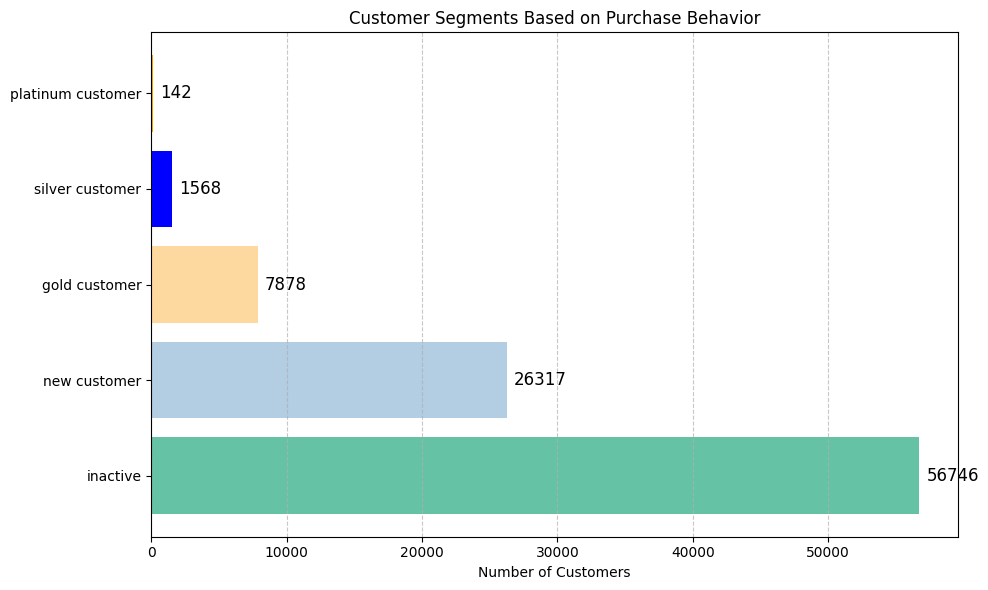

In [15]:
""" Bar chart """
# Step 1: Run KMeans
kn=5
kmeans = KMeans(n_clusters=kn, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# See cluster center tendencies
import numpy as np
cluster_centers = kmeans.cluster_centers_

# Assign labels based on behavior
# Example: map low freq/monetary = inactive, mid = new, high = loyal
cluster_order = np.argsort([center[0] for center in cluster_centers])  # by frequency

labels = ['inactive', 'new customer', 'gold customer', 'silver customer', 'platinum customer']
label_map = {cluster_order[i]: labels[i] for i in range(kn)}
df['segment'] = df['cluster'].map(label_map)

########
# Step 3: Plot the labeled segments
segment_counts = df['segment'].value_counts().reindex(labels)

colors = ['#66c2a5', '#b3cde3', '#fdd9a0', 'blue', 'orange']
plt.figure(figsize=(10, 6))
bars = plt.barh(segment_counts.index, segment_counts.values, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=12)

plt.xlabel('Number of Customers')
plt.title('Customer Segments Based on Purchase Behavior')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
""" Scatter plot each cluster """
# Find median in each clusters
cluster_medians = df.groupby('cluster')[['frequency']].median().reset_index()

# Sort clusters by median frequency
sorted_clusters = cluster_medians.sort_values('frequency').reset_index(drop=True)
labels = ['inactive', 'new customer', 'gold customer', 'silver customer', 'platinum customer']  # adjust if you used a different number of clusters
colors = ['#66c2a5', '#b3cde3', '#fdd9a0', 'blue', 'orange']

# Create mapping: cluster index -> label
label_map = {row['cluster']: labels[i] for i, row in sorted_clusters.iterrows()}
cluster_medians['label'] = cluster_medians['cluster'].map(label_map)

# Plot as scatter chart
plt.figure(figsize=(8, 5))
plt.scatter(
    cluster_medians['cluster'],
    cluster_medians['frequency'],
    s=200,
    color=colors,
    edgecolors='black'
)

# Annotate points
for i, row in cluster_medians.iterrows():
    plt.text(row['cluster'] + 0.05, row['frequency'], row['label'], fontsize=11)

# Format axes
plt.title('Median Purchase Frequency per Cluster')
plt.xlabel('Median Recency')
plt.ylabel('Median Frequency')
plt.xticks(cluster_medians['cluster'])
plt.grid(True)
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1704895915.py, line 20)